In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

In [2]:
tags_data = pd.read_csv('stage_2_train_labels.csv')
columns = ['patientId', 'Target']

tags_data = tags_data.filter(columns)
tags_data.head(10)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1
5,00436515-870c-4b36-a041-de91049b9ab4,1
6,00569f44-917d-4c86-a842-81832af98c30,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,1


In [3]:
training_tags, val_tags = train_test_split(tags_data.values, test_size=0.1)
print(training_tags.shape)
print(val_tags.shape)

(27204, 2)
(3023, 2)


In [4]:
print(f'patientId Column: {training_tags[0][0]}, Target Column: {training_tags[0][1]}')

patientId Column: 3e881f10-28aa-4626-a79a-50cc014b7a1a, Target Column: 1


# Training and Validation Paths

In [5]:
training_p = 'train_images'
testing_p = 'test_images'

training_paths = [os.path.join(training_p, image[0]) for image in training_tags]
validation_paths = [os.path.join(training_p, image[0]) for image in val_tags]

print(len(training_paths))
print(len(validation_paths))

27204
3023


<h2> Transformers


In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

<h2> Custom Dataset

In [7]:
class DS(data.Dataset):
    
    def __init__(self, paths, tags, transform=None):
        self.paths = paths
        self.tags = tags
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        tag = self.tags[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, tag
    
    def __len__(self):
        
        return len(self.paths)

In [8]:
training_data = DS(training_paths, training_tags, transform=transform)
image = iter(training_data)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))

Tensor:tensor([[[0.1176, 0.1255, 0.1255,  ..., 0.7922, 0.7961, 0.7529],
         [0.1255, 0.1294, 0.1333,  ..., 0.8471, 0.8471, 0.8039],
         [0.1255, 0.1294, 0.1294,  ..., 0.8431, 0.8431, 0.8000],
         ...,
         [0.5529, 0.5725, 0.5608,  ..., 0.1255, 0.2706, 0.4510],
         [0.5451, 0.5608, 0.5569,  ..., 0.1098, 0.1255, 0.1725],
         [0.5059, 0.5137, 0.5137,  ..., 0.1059, 0.1098, 0.1098]],

        [[0.1176, 0.1255, 0.1255,  ..., 0.7922, 0.7961, 0.7529],
         [0.1255, 0.1294, 0.1333,  ..., 0.8471, 0.8471, 0.8039],
         [0.1255, 0.1294, 0.1294,  ..., 0.8431, 0.8431, 0.8000],
         ...,
         [0.5529, 0.5725, 0.5608,  ..., 0.1255, 0.2706, 0.4510],
         [0.5451, 0.5608, 0.5569,  ..., 0.1098, 0.1255, 0.1725],
         [0.5059, 0.5137, 0.5137,  ..., 0.1059, 0.1098, 0.1098]],

        [[0.1176, 0.1255, 0.1255,  ..., 0.7922, 0.7961, 0.7529],
         [0.1255, 0.1294, 0.1333,  ..., 0.8471, 0.8471, 0.8039],
         [0.1255, 0.1294, 0.1294,  ..., 0.8431, 0.8

In [9]:
img.shape

torch.Size([224, 224, 3])

<h2> Dataloader


In [10]:
training_data = DS(training_paths, training_tags, transform=transform)
val_dataset = DS(validation_paths, val_tags, transform=transform)
t_loader = data.DataLoader(dataset=training_data, batch_size=128, shuffle=True)
v_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [11]:
batch = iter(t_loader)
img, tags = next(batch)


<h2>GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h2> ResNet18 from Torchvision (Pretrained) - From Pytorch Tutorials

In [13]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2> Train and Evaluate

In [15]:
epochs = 10

num_step = len(t_loader)

for e in range(epochs):
    for i, (img, tags) in tqdm(enumerate(t_loader)):
        img = img.to(device)
        tags = tags.to(device)

        res = model(img)
        loss = criterion(res, tags)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                   .format(e+1, epochs, i+1, num_step, loss.item()))


    accurate = 0
    total = 0  
    for img, tags in tqdm(v_loader):
        img = img.to(device)
        tags = tags.to(device)
        pred = model(img)
        _, predicted = torch.max(pred, 1)
        total += tags.size(0)
        accurate += (tags == predicted).sum()
    print(f'Epoch: {e+1}/{epochs}, Validation Accuracy: {accurate/total}')

213it [12:02,  3.39s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:19<00:00,  3.30s/it]
0it [00:00, ?it/s]

Epoch: 1/10, Validation Accuracy: 0.7998676896095276


213it [12:13,  3.45s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:22<00:00,  3.43s/it]
0it [00:00, ?it/s]

Epoch: 2/10, Validation Accuracy: 0.8124379515647888


213it [12:16,  3.46s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:22<00:00,  3.46s/it]
0it [00:00, ?it/s]

Epoch: 3/10, Validation Accuracy: 0.8203771114349365


213it [12:14,  3.45s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:20<00:00,  3.36s/it]
0it [00:00, ?it/s]

Epoch: 4/10, Validation Accuracy: 0.8233543038368225


213it [12:12,  3.44s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:19<00:00,  3.30s/it]
0it [00:00, ?it/s]

Epoch: 5/10, Validation Accuracy: 0.8236851096153259


213it [11:58,  3.38s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:19<00:00,  3.32s/it]
0it [00:00, ?it/s]

Epoch: 6/10, Validation Accuracy: 0.830962598323822


213it [11:58,  3.38s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:19<00:00,  3.31s/it]
0it [00:00, ?it/s]

Epoch: 7/10, Validation Accuracy: 0.8286470174789429


213it [12:27,  3.51s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:24<00:00,  3.51s/it]
0it [00:00, ?it/s]

Epoch: 8/10, Validation Accuracy: 0.8296394348144531


213it [12:46,  3.60s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:24<00:00,  3.52s/it]
0it [00:00, ?it/s]

Epoch: 9/10, Validation Accuracy: 0.8349322080612183


213it [12:25,  3.50s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:19<00:00,  3.30s/it]

Epoch: 10/10, Validation Accuracy: 0.8428713083267212


In [16]:
model.eval()

accurate = 0
total = 0  
for img, tags in tqdm(v_loader):
    img = img.to(device)
    tags = tags.to(device)
    pred = model(img)
    _, predicted = torch.max(pred, 1)
    total += tags.size(0)
    accurate += (tags == predicted).sum()
print(f'Val_Acc: {accurate/total}')

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:19<00:00,  3.30s/it]

Val_Acc: 0.8432021141052246


<function matplotlib.pyplot.show(*args, **kw)>

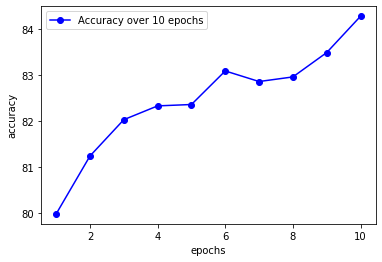

In [17]:
x_var=[1,2,3,4,5,6,7,8,9,10]
y_var=[79.98, 81.24, 82.03, 82.33, 82.36,83.09, 82.86, 82.96, 83.49, 84.28]
plt.plot(x_var, y_var,'b-o',label='Accuracy over 10 epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show